In [3]:
from finalmodel import finalmodel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df, model, predictions, features, X, y = finalmodel()

In [6]:
median = np.median(X, axis=0)
feature_df = pd.DataFrame(data=np.column_stack((np.round(model.coef_.T,4), np.round(median, 4))), index=features, columns=["coef", "median"])
intercept = pd.DataFrame(data = {'coef':model.intercept_,'median':1}, index=['intercept'])

feature_df = pd.concat([intercept, feature_df], axis=0)
# feature_df.to_excel("features.xlsx")

In [9]:
# Median churn percentage
median_churn = np.round((1 /(1 + np.exp(-np.sum(np.multiply(feature_df['coef'],feature_df['median']))))),4)*100

In [10]:
median_churn

51.49

## Heat map

### Probability of churn plotting "Times contacted / quarter" and "Associated Deals"

In [11]:
interaction_1 = df[['callsPerQuarter','associateddeals']].describe()
interaction_1.drop('count', inplace=True)
interaction_1['associatedDeals'] = interaction_1['associateddeals']**2
interaction_1['callsPerQuarter'] = interaction_1['callsPerQuarter']**4

interaction_1

,callsPerQuarter,associateddeals,associatedDeals
mean,1.317421,1.254452,1.573650
std,0.017796,0.733368,0.537828
min,0.010000,0.100000,0.010000
25%,0.692462,1.000000,1.000000
50%,1.425604,1.414214,2.000000
75%,2.611355,1.732051,3.000000
max,56.011521,4.582576,21.000000


In [12]:
# Create values to create heatmap
callsPerQuarter = np.linspace(0, 4, 5)
assocDeals = np.linspace(0,8,5)

# Create dataframe
heatmap_df = pd.DataFrame(columns=['times contacted/quarter','associated deals','churn'])

interaction_features_df = feature_df.copy()

for call in callsPerQuarter:
    for deal in assocDeals:
            # Box-Cox for the model
            if call == 0:
                call_trans = 0.01**(1/4)
            else:
                call_trans = call**(1/4)
            
            if deal == 0:
                deal_trans = 0.01**(1/4)
            else:
                deal_trans = deal**(1/4)

            # Update needed features
            interaction_features_df.loc['assoccontacts associateddeals','median'] = (interaction_features_df.loc['assoccontacts associateddeals','median']/interaction_features_df.loc['associateddeals','median'])*deal_trans # Here we need to divide out the median deal from the number, then multiply in the actual deal
            interaction_features_df.loc['callsPerQuarter','median'] = call_trans
            interaction_features_df.loc['associateddeals','median'] = deal_trans
            interaction_features_df.loc['callsPerQuarter associateddeals','median'] = call_trans*deal_trans

            # Update churn percentage
            median_churn = np.round((1 /(1 + np.exp(-np.sum(np.multiply(interaction_features_df['coef'],interaction_features_df['median']))))),4)*100

            # Add in to dictionary
            heatmap_df = heatmap_df.append({'times contacted/quarter': call, 'associated deals': deal,'churn': median_churn}, ignore_index=True)

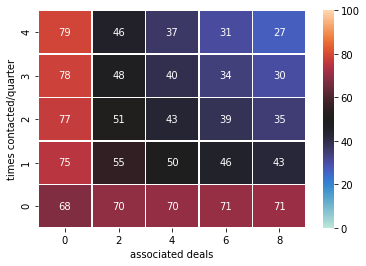

In [13]:
## Organize Columns
heatmap_df['times contacted/quarter'] = heatmap_df['times contacted/quarter'].astype(int)
heatmap_df['associated deals'] = heatmap_df['associated deals'].astype(int)

## Create Heatmaps
heatmap_final = heatmap_df.pivot('times contacted/quarter', "associated deals", "churn").sort_values("times contacted/quarter", ascending=False)
ax = sns.heatmap(heatmap_final, vmin=0, vmax=100, center=50, annot=True, linewidths=0.5)

### Probability of churn plotting "MRR" and "Associated Contacts"

In [14]:
interaction_2 = df[['MRR','assoccontacts']].describe()
interaction_2.drop('count', inplace=True)
interaction_2['MRR'] = np.exp(interaction_2['MRR'])
interaction_2['assoccontacts'] = interaction_2['assoccontacts']**4

interaction_2

,MRR,assoccontacts
mean,1166.691216,5.134189
std,3.335672,0.266634
min,95.000000,0.010000
25%,577.356360,2.000000
50%,1216.000000,5.000000
75%,2171.393459,11.000000
max,40355.000000,855.000000


In [15]:
# Create values to create heatmap
MRR = np.linspace(100, 40000, 5)
assoccontacts = np.linspace(0,12,5)

# Create dataframe
heatmap_df = pd.DataFrame(columns=['MRR','associated contacts','churn'])

interaction_features_df = feature_df.copy()

for revenue in MRR:
    for contacts in assoccontacts:
            # Box-Cox for the model
            revenue_trans = np.log(revenue)
            
            if contacts == 0:
                contacts_trans = 0.01**(1/4)
            else:
                contacts_trans = contacts_trans**(1/4)

            # Update needed features
            median_assoccontacts = (interaction_features_df.loc['assoccontacts associateddeals','median']/interaction_features_df.loc['associateddeals','median'])

            interaction_features_df.loc['assoccontacts associateddeals','median'] = (interaction_features_df.loc['assoccontacts associateddeals','median']/median_assoccontacts)*contacts_trans # Here we need to divide out the median deal from the number, then multiply in the actual deal
            interaction_features_df.loc['assoccontacts MRR','median'] = revenue_trans*contacts_trans

            # Update churn percentage
            median_churn = np.round((1 /(1 + np.exp(-np.sum(np.multiply(interaction_features_df['coef'],interaction_features_df['median']))))),4)*100

            # Add in to dictionary
            heatmap_df = heatmap_df.append({'MRR': revenue, 'associated contacts': contacts,'churn': median_churn}, ignore_index=True)

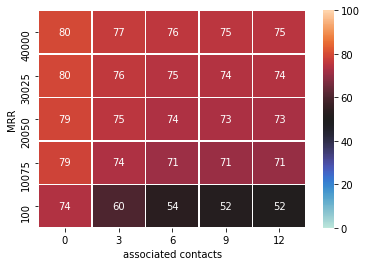

In [16]:
## Organize Columns
heatmap_df['MRR'] = heatmap_df['MRR'].astype(int)
heatmap_df['associated contacts'] = heatmap_df['associated contacts'].astype(int)

## Create Heatmaps
heatmap_final = heatmap_df.pivot("MRR", 'associated contacts', "churn").sort_values("MRR", ascending=False)
ax = sns.heatmap(heatmap_final, vmin=0, vmax=100, center=50, annot=True, linewidths=0.5)

### Probability of churn plotting "Associated deals", "Associated Contacts", and "times contacted/quarter"

In [17]:
interaction_3 = df[['associateddeals','assoccontacts','callsPerQuarter']].describe()
interaction_3['callsPerQuarter'] = interaction_3['callsPerQuarter']**4
interaction_3['associateddeals'] = interaction_3['associateddeals']**2
interaction_3['assoccontacts'] = interaction_3['assoccontacts']**4

interaction_3

,associateddeals,assoccontacts,callsPerQuarter
count,58564.000000,3.429742e+09,3.429742e+09
mean,1.573650,5.134189e+00,1.317421e+00
std,0.537828,2.666338e-01,1.779595e-02
min,0.010000,1.000000e-02,1.000000e-02
25%,1.000000,2.000000e+00,6.924620e-01
50%,2.000000,5.000000e+00,1.425604e+00
75%,3.000000,1.100000e+01,2.611355e+00
max,21.000000,8.550000e+02,5.601152e+01


In [18]:
# Create values to create heatmap
assocDeals = np.linspace(0,8,5)
assoccontacts = np.linspace(0,12,5)

# Create dataframe for 25th, 50th, and 75th percentiles of callsPerQuarter
heatmap_df = [pd.DataFrame(columns=['associated deals','associated contacts','churn']),pd.DataFrame(columns=['associateddeals','associated contacts','churn']), pd.DataFrame(columns=['associateddeals','associated contacts','churn'])]

interaction_features_df = feature_df.copy()

for deals in assocDeals:
    for contacts in assoccontacts:
            # Box-Cox for the model
            if deals == 0:
                deal_trans = 0.01**(1/4)
            else:
                deal_trans = deal**(1/4)
            
            if contacts == 0:
                contacts_trans = 0.01**(1/4)
            else:
                contacts_trans = contacts_trans**(1/4)

            calls_25_trans = interaction_3.loc['25%','callsPerQuarter']**(1/4)
            calls_50_trans = interaction_3.loc['50%','callsPerQuarter']**(1/4)
            calls_75_trans = interaction_3.loc['75%','callsPerQuarter']**(1/4)
            calls = [calls_25_trans, calls_50_trans, calls_75_trans]

            # Update needed features
            median_assoccontacts = (interaction_features_df.loc['assoccontacts associateddeals','median']/interaction_features_df.loc['associateddeals','median'])
            interaction_features_df.loc['assoccontacts MRR','median'] = (interaction_features_df.loc['assoccontacts MRR','median']/median_assoccontacts)*contacts_trans # Here we need to divide out the median deal from the number, then multiply in the actual deal

            interaction_features_df.loc['assoccontacts associateddeals','median'] = deal_trans*contacts_trans
            interaction_features_df.loc['associateddeals','median'] = deal_trans

            # Update for each percentile of callsPerQuarter
            for i in range(len(calls)):
                interaction_features_df.loc['callsPerQuarter associateddeals','median'] = calls[i]*deal_trans
                interaction_features_df.loc['callsPerQuarter','median'] = calls[i]

                # Update churn percentage
                median_churn = np.round((1 /(1 + np.exp(-np.sum(np.multiply(interaction_features_df['coef'],interaction_features_df['median']))))),4)*100

                # Add in to dictionary
                heatmap_df[i] = heatmap_df[i].append({'associated deals': deals, 'associated contacts': contacts,'churn': median_churn}, ignore_index=True)

Text(0.5, 1.0, 'Times contacted/quarter @ 75% Percentile')

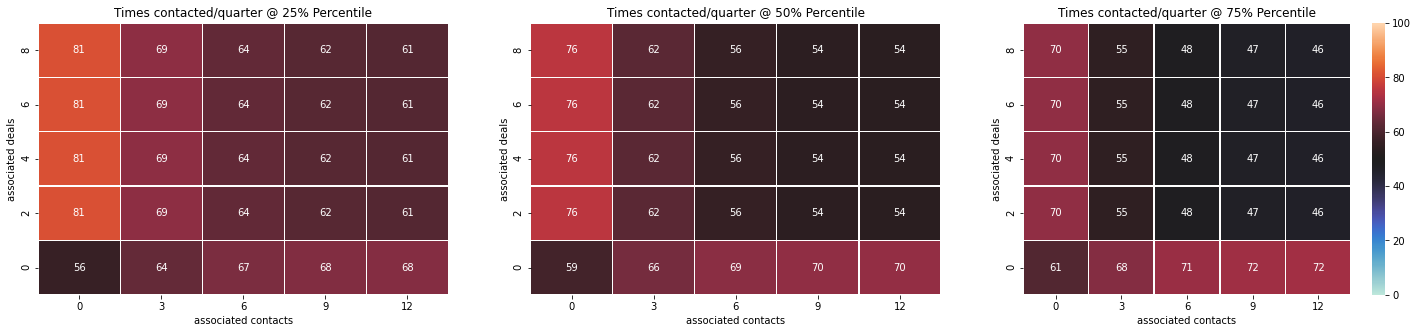

In [19]:
## Organize Columns
heatmap_df[0]['associated deals'] = heatmap_df[0]['associated deals'].astype(int)
heatmap_df[0]['associated contacts'] = heatmap_df[0]['associated contacts'].astype(int)
heatmap_df[1]['associated deals'] = heatmap_df[1]['associated deals'].astype(int)
heatmap_df[1]['associated contacts'] = heatmap_df[1]['associated contacts'].astype(int)
heatmap_df[2]['associated deals'] = heatmap_df[2]['associated deals'].astype(int)
heatmap_df[2]['associated contacts'] = heatmap_df[2]['associated contacts'].astype(int)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25,5))

## Create Heatmaps
heatmap_final_25 = heatmap_df[0].pivot('associated deals', 'associated contacts', "churn").sort_values("associated deals", ascending=False)
heatmap_final_50 = heatmap_df[1].pivot('associated deals', 'associated contacts', "churn").sort_values("associated deals", ascending=False)
heatmap_final_75 = heatmap_df[2].pivot('associated deals', 'associated contacts', "churn").sort_values("associated deals", ascending=False)

sns.heatmap(heatmap_final_25, vmin=0, vmax=100, center=50, annot=True, linewidths=0.5,cbar=False,ax=ax1)
sns.heatmap(heatmap_final_50, vmin=0, vmax=100, center=50, annot=True, linewidths=0.5,cbar=False,ax=ax2)
sns.heatmap(heatmap_final_75, vmin=0, vmax=100, center=50, annot=True, linewidths=0.5,ax=ax3)

ax1.set_title('Times contacted/quarter @ 25% Percentile')
ax2.set_title('Times contacted/quarter @ 50% Percentile')
ax3.set_title('Times contacted/quarter @ 75% Percentile')

## Output by Customer Predictions

In [8]:
from dataprep.dataPrep import cleanData

df = cleanData("PSCCustomerData.csv", boxcox=False)

df.query('churn !=1')[['companyID', 'callsPerQuarter','associateddeals','sessionsPerDay','callcycle_numeric','assoccontacts','MRR']].to_excel("customers.xlsx", index=False)